<a href="https://colab.research.google.com/github/tsakailab/DeepLS/blob/main/demo/demo_background_subtraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Deep learning for Foreground Segmentation Exploiting Low-rank and Sparse Priors

# import pytorch and fix seed

In [1]:
import torch
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    print(torch.cuda.memory_allocated())
    print(torch.cuda.memory_reserved())
    torch.cuda.empty_cache()
import random
import numpy as np
def torch_fix_seed(seed=1):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
torch_fix_seed(seed=1)

Tesla T4
0
0


In [2]:
#@title some functions for visualization
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
from torchvision.utils import make_grid

def anim_make(MM, hw, vmin=0, vmax=1,interval=50):
    fig = plt.figure(figsize=(hw[1]/33*len(MM),hw[0]/33))
    ims = []
    for i in range(MM[0].shape[1]):
        V = []
        for l in range(len(MM)):
            V.append(MM[l][:,i].reshape(hw))
        #ims.append( [plt.imshow(np.abs(M[:,i]).reshape(hw), cmap='gray', vmin=vmin, vmax=vmax)] )
        ims.append( [plt.imshow(np.abs(np.hstack(V)), cmap='gray', vmin=vmin, vmax=vmax)] )
    anim = animation.ArtistAnimation(fig, ims, interval=interval, repeat=False, blit=True)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
    plt.close(anim._fig)
    return anim

def anim_make_for_UNet(MM, hw, vmin=0, vmax=1,interval=50):
    fig = plt.figure(figsize=(hw[1]/33*len(MM),hw[0]/33))
    ims = []
    for i in range(MM[0].shape[0]):
        V = []
        for l in range(len(MM)):
            # print(MM[l][i].shape, MM[l].shape)
            V.append(MM[l][i])
        ims.append( [plt.imshow(np.abs(np.hstack(V)), cmap='gray', vmin=vmin, vmax=vmax)] )
    anim = animation.ArtistAnimation(fig, ims, interval=interval, repeat=False, blit=True)
    plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg' # For google colab
    plt.close(anim._fig)
    return anim

def make_and_plot_grid(data, nrows=16):
    fig = plt.figure(figsize=(nrows*2,8))
    data = torch.tensor(data).unsqueeze(1)
    grid = make_grid(data).permute(1,2,0)
    plt.imshow(grid)


def plot_loss(historyr):
    plt.rcParams["font.size"] = 16
    fig = plt.figure()
    plt.plot(list(loss_hist['total'].values()), label='Total loss')
    plt.plot(list(loss_hist['nuclear'].values()), label='Nuclear norm')
    plt.plot(list(loss_hist['l1'].values()), label='L1 norm')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()

In [3]:
#@title ## Download and extract data zipfile
import zipfile
import os

root_dir = "/tmp/hall"
if not os.path.isdir(root_dir):
    !wget --no-check-certificate --show-progress -q\
        "https://www.dropbox.com/s/hof9g5af1964j8r/hall.zip?dl=1" \
        -O "/tmp/hall.zip"
    
    zip_filename = "/tmp/hall.zip"
    zip_ref = zipfile.ZipFile(zip_filename, 'r')
    zip_ref.extractall(root_dir)
    zip_ref.close()

imageseq_files = sorted(os.listdir(root_dir))

from PIL import Image
import numpy as np

im = np.array(Image.open(root_dir + '/' + imageseq_files[0]))
imageseq = []
for filename in imageseq_files:
    fullname = root_dir + '/' + filename
    if os.path.isfile(fullname):
        imageseq.append(np.array(Image.open(fullname).convert('L')))

imageseq = np.array(imageseq)
print(imageseq.shape)


(3584, 144, 176)


# Randomly select training data and prepare test data.

(25344, 50)
0.0 1.0


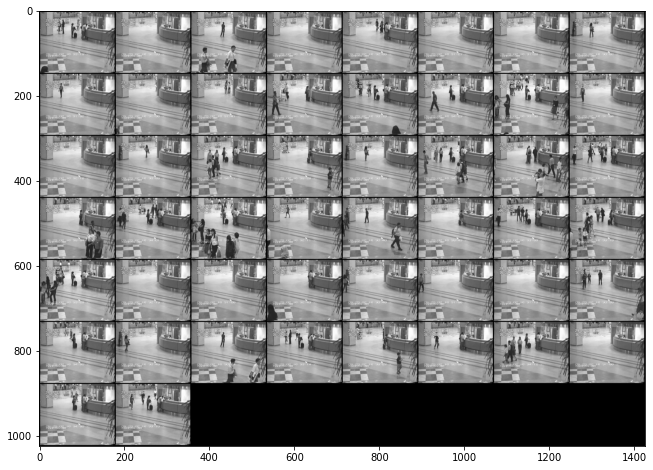

In [4]:
n_frames = 50

training_index = np.random.permutation(len(imageseq))[:n_frames]

DDseq = imageseq[training_index,:,:].copy().astype(float) / 255.
DD = DDseq.reshape(n_frames,imageseq.shape[1]*imageseq.shape[2]).T

print(DD.shape)
print(DD.min(), DD.max())

m, n = imageseq.shape[1:]
make_and_plot_grid(DDseq)

[  93  102  219  268  351  368  393  397  420  557  574  749  756  813
  846  895 1006 1028 1047 1065 1197 1219 1239 1248 1536 1607 1653 1813
 1847 1863 1895 2008 2084 2126 2313 2340 2362 2421 2443 2451 2568 2842
 2852 3114 3145 3230 3239 3395 3475 3508]


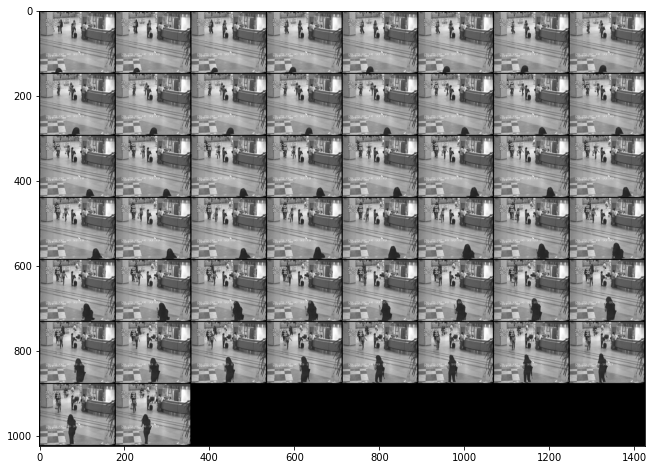

In [5]:
print(np.sort(training_index))

D_test = imageseq[1926-50:1926,:,:].copy().astype(float) / 255.
DD_test = torch.tensor(D_test.reshape(D_test.shape[0], imageseq.shape[1]*imageseq.shape[2]).T).float().cuda()
make_and_plot_grid(D_test)

# Try our unsupervised deep learning approach!

In [9]:
#@title initialize our model
class dualframeUNet(torch.nn.Module):
    def __init__(self, in_channels, middle_channels_c, output_channels):
        super().__init__()
        def double_conv(in_channels,out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 3,padding=1, padding_mode="reflect"),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(out_channels, out_channels, 3,padding=1, padding_mode="reflect"),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True)
            )
        def middle_conv(in_channels,out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 3,padding=1, padding_mode="reflect"),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(out_channels, in_channels, 3,padding=1, padding_mode="reflect"),
                torch.nn.BatchNorm2d(in_channels),
                torch.nn.ReLU(inplace=True)
            ) 
        def out_conv(in_channels,out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, in_channels//2, 3,padding=1, padding_mode="reflect"),
                torch.nn.BatchNorm2d(in_channels//2),
                torch.nn.ReLU(inplace=True),
                torch.nn.Conv2d(in_channels//2, out_channels, 3,padding=1, padding_mode="reflect"),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.ReLU(inplace=True)
            )
        def last_conv(in_channels,out_channels):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, 1, padding=0, bias=False)
            )
        def upsample(in_channels, out_channels, scale_factor, mode):
            return torch.nn.Sequential(
                torch.nn.Upsample(scale_factor=scale_factor, mode=mode),
            )
        
        self.convs1 = double_conv(in_channels,middle_channels_c)
        self.downsample1 = torch.nn.MaxPool2d(2)
        self.convs2 = double_conv(middle_channels_c,middle_channels_c*2)
        self.downsample2 = torch.nn.MaxPool2d(2)
        self.convs3 = middle_conv(middle_channels_c*2,middle_channels_c*4)
        
        self.upsample2_S = upsample(middle_channels_c*2, middle_channels_c*2, 2, 'bilinear')
        self.dconvs2_S = out_conv(middle_channels_c*4,middle_channels_c*1)      
        self.upsample1_S = upsample(middle_channels_c*1, middle_channels_c*1, 2, 'bilinear')
        
        self.dconvs1_S = double_conv(middle_channels_c*2,middle_channels_c)
        self.last_S = last_conv(middle_channels_c,output_channels)

    def forward(self, x):
        #encoding                           #x:(B,input_channels,H,W)
        convs1 = self.convs1(x)             #x:(B,c,H,W)
        x_down1 = self.downsample1(convs1)  #x:(B,c,H/2,W/2)
        convs2 = self.convs2(x_down1)       #x:(B,c*2,H/2,W/2)
        x_down2 = self.downsample1(convs2)  #x:(B,c*2,H/4,W/4)
        x = self.convs3(x_down2)            #x:(B,c*2,H/4,W/4)
        
        #decoding
        x = self.upsample2_S(x - x_down2)   #x:(B,c*2,H/2,W/2)
        x = torch.cat([x, convs2], dim=1)   #x:(B,c*4,H/2,W/2)
        x = self.dconvs2_S(x)               #x:(B,c,H/2,W/2)
        
        x = self.upsample1_S(x - x_down1)   #x:(B,c,H,W)
        x = torch.cat([x, convs1], dim=1)   #x:(B,c*2,H,W)
        x = self.dconvs1_S(x)               #x:(B,c,H,W)
        
        out_S = self.last_S(x)              #x:(B,c,H,W) out_S:(B,1,H,W)

        return out_S
from torchsummary import summary
model = dualframeUNet(in_channels=1, middle_channels_c=32, output_channels=1).cuda()
summary(model, (1, 144, 176))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 144, 176]             320
       BatchNorm2d-2         [-1, 32, 144, 176]              64
              ReLU-3         [-1, 32, 144, 176]               0
            Conv2d-4         [-1, 32, 144, 176]           9,248
       BatchNorm2d-5         [-1, 32, 144, 176]              64
              ReLU-6         [-1, 32, 144, 176]               0
         MaxPool2d-7           [-1, 32, 72, 88]               0
            Conv2d-8           [-1, 64, 72, 88]          18,496
       BatchNorm2d-9           [-1, 64, 72, 88]             128
             ReLU-10           [-1, 64, 72, 88]               0
           Conv2d-11           [-1, 64, 72, 88]          36,928
      BatchNorm2d-12           [-1, 64, 72, 88]             128
             ReLU-13           [-1, 64, 72, 88]               0
        MaxPool2d-14           [-1, 64,

In [10]:
#@title implemention of the computation of two norms.
Nuclear_norm = lambda x: torch.sum(torch.svd(x)[1])
L1_norm = lambda x: torch.sum(torch.abs(x))

In [11]:
#@title hyperparameter setting
num_epochs = 500
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
lambda_loss = 1/np.sqrt(max(m, n))

100%|██████████| 500/500 [03:28<00:00,  2.39it/s, loss=1.03e+3]


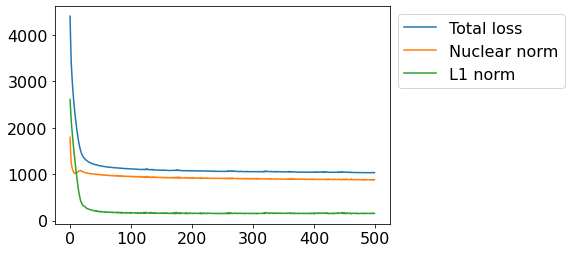

In [12]:
#@title run training
from tqdm import tqdm
from collections import OrderedDict

# prepare training data
DD_UNet = torch.tensor(DD.T.reshape(DD.shape[1], 144, 176)).unsqueeze(1).float().cuda()

history_loss_Unet = []
loss_hist = {}
loss_hist['total'] = {}
loss_hist['l1'] = {}
loss_hist['nuclear'] = {}

bar = tqdm(total = num_epochs, position=0, leave=True)
for iter in range(num_epochs):
    total_loss = 0.

    # predict foreground
    S = model(DD_UNet)

    # compute loss
    nloss = Nuclear_norm(((DD_UNet-S).view(DD_UNet.shape[0], -1)).T)
    lloss = L1_norm(S.view(DD_UNet.shape[0], -1))*lambda_loss
    loss = nloss + lloss

    # optimize model parameter
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    history_loss_Unet.append(total_loss)
    bar.set_postfix(OrderedDict(loss=total_loss))
    loss_hist['total'][iter] = loss.item()
    loss_hist['l1'][iter] = lloss.item()
    loss_hist['nuclear'][iter] = nloss.item()
    bar.update(1)
bar.close()
### Results
plot_loss(loss_hist)
model = model.eval()

In [13]:
#@title output of our model (for train set)
D_UNet = DD_UNet.cpu().squeeze(1)                       # D         :(batch size, image height, image width)
with torch.no_grad():
    S_UNet = model(DD_UNet).detach().cpu().squeeze(1)   # S=UNet(D) :(batch size, image height, image width)
L_UNet = (D_UNet-S_UNet).detach().cpu().squeeze(1)      # L=D-S     :(batch size, image height, image width)

DLDiffanim = anim_make_for_UNet([  D_UNet,  L_UNet,  S_UNet  ], (imageseq.shape[1],imageseq.shape[2]), interval=300)
HTML(DLDiffanim.to_html5_video())

In [14]:
#@title output of our model (for test sequence)
D_UNet = torch.tensor(D_test).cpu().squeeze(1)                       # D         :(batch size, image height, image width)
with torch.no_grad():
    S_UNet = model(torch.tensor(D_test).float().cuda().unsqueeze(1)).detach().cpu().squeeze(1)   # S=UNet(D) :(batch size, image height, image width)
L_UNet = (D_UNet-S_UNet).detach().cpu().squeeze(1)                  # L=D-S     :(batch size, image height, image width)

DLDiffanim = anim_make_for_UNet([  D_UNet,  L_UNet,  S_UNet  ], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLDiffanim.to_html5_video())

# Run RPCA to separate matrix into redundant background and sparse foreground

[ 50/500]: loss = 944.1356,  
[100/500]: loss = 939.9577,  
[150/500]: loss = 939.5146,  
[200/500]: loss = 939.3898,  
[250/500]: loss = 939.3479,  
[300/500]: loss = 939.3342,  
[350/500]: loss = 939.3272,  
[400/500]: loss = 939.3195,  
[450/500]: loss = 939.3160,  
[500/500]: loss = 939.3141,  
7684.0550899505615  [ms]


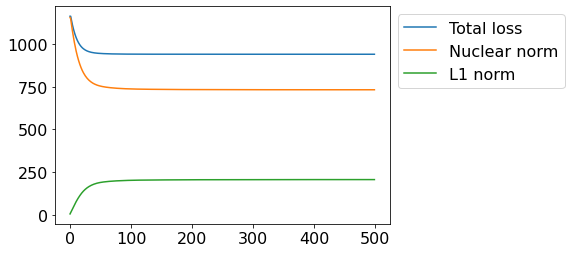

In [6]:
#@title RPCA (for comparison)
### Definitions

soft = lambda z, th: z.sign() * (z.abs() - th).max(torch.tensor(0., device=device))

def svt(input, th):
    u, s, v = torch.svd(input)
    return torch.matmul(torch.matmul(u, torch.diag_embed(soft(s,th))), torch.transpose(v, -2, -1)), u, s, v


### Algorithm
from time import time
D = torch.from_numpy(DD.astype(np.float32)).to(device).clone()
# D = torch.rand((79,256*256)).to(device).clone()

# Hyperparameters
rcp_rho = 1./ 1.
m, n = D.shape[0], D.shape[1]
ls = 1./np.sqrt(max(m,n))


# Using L1Loss with prox
# nucloss =lambda x:  torch.sum(torch.linalg.svdvals(x))
nucloss =lambda x: torch.sum(torch.svd(x)[1])
l1loss = lambda x: torch.sum(torch.abs(x))


S, U  = 0, 0
t = time()
num_iter = 500
display_step = num_iter // 10
loss_hist = {}
loss_hist['total'] = {}
loss_hist['l1'] = {}
loss_hist['nuclear'] = {}

for iter in range(num_iter):
    with torch.no_grad():
        L = svt(D - S - U, rcp_rho)[0]
        S = soft(D - L - U, ls*rcp_rho)
        U = U + L + S - D
        objJ = nucloss(L) + ls * l1loss(S)
        loss_hist['total'][iter] = objJ.item()
        loss_hist['l1'][iter] = ls * l1loss(S).item()
        loss_hist['nuclear'][iter] = nucloss(L).item()

    # history_loss.append(objJ.item())

    if (iter+1) % display_step == 0:
        print ('[{:3d}/{}]: loss = {:.4f},  '.format(iter+1, num_iter, objJ))
fin = (time()-t)*1000
print(fin, ' [ms]')
### Results
plot_loss(loss_hist)

In [7]:
#@title Output of RPCA (for train set)
DLDiffanim = anim_make([  D.detach().cpu(),  L.detach().cpu(),  S.detach().cpu()  ], (imageseq.shape[1],imageseq.shape[2]), interval=300)
HTML(DLDiffanim.to_html5_video())

In [8]:
#@title vector rejection and vector projection
u, s, v = torch.svd((L))
vector_projection = torch.matmul(u, torch.matmul(u.T, DD_test)).detach().cpu()
vector_rejection = (DD_test - vector_projection.cuda()).detach().cpu()
DLDiffanim = anim_make([  DD_test.detach().cpu(),  vector_projection,  vector_rejection  ], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLDiffanim.to_html5_video())

# Let's change camera geometry!

In [15]:
from torchvision import transforms

## 1.2x zoom
scale = 1.2
res = torch.nn.Sequential(
    transforms.Resize((int(144*scale), int(176*scale))),
    transforms.CenterCrop((144, 176)),
)

In [16]:
# test set
changed_D_test = res(torch.tensor(D_test))
changed_DD_test = changed_D_test.reshape(changed_D_test.shape[0], -1).T.float().cuda()
print(changed_D_test.shape)

torch.Size([50, 144, 176])


In [17]:
#@title output of ours
D_UNet = changed_D_test.cpu().squeeze(1)
with torch.no_grad():
    S_UNet = model(changed_D_test.float().cuda().unsqueeze(1)).detach().cpu().squeeze(1)
L_UNet = (D_UNet-S_UNet).detach().cpu().squeeze(1)
DLDiffanim = anim_make_for_UNet([  D_UNet,  L_UNet,  S_UNet  ], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLDiffanim.to_html5_video())

In [19]:
#@title output of RPCA
u, s, v = torch.svd((L))
vector_projection = torch.matmul(u, torch.matmul(u.T, changed_DD_test)).detach().cpu()
vector_rejection = (changed_DD_test - vector_projection.cuda()).detach().cpu()
DLDiffanim = anim_make([  changed_DD_test.detach().cpu(),  vector_projection,  vector_rejection  ], (imageseq.shape[1],imageseq.shape[2]))
HTML(DLDiffanim.to_html5_video())